Using device: cuda


C:\Users\mathi\AppData\Local\Temp\ipykernel_27604\3319944353.py:178: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pinn.net.load_state_dict(torch.load(r"C:\Users\mathi\Deskt

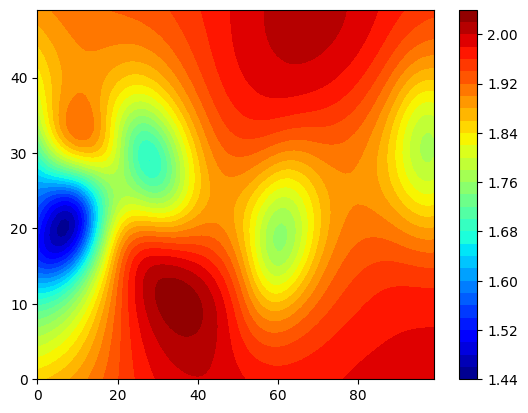

In [9]:
# Créateur du code ComputationalDomain
import torch
import torch.nn as nn
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import matplotlib.animation as animation

# Viscosité cinématique
nu = 0.01

# Classe pour résoudre les équations de Navier-Stokes
class NavierStokes():
    def __init__(self, X, Y, T, u, v, device):
        self.device = device
        # Convertir les données en tenseurs PyTorch et les déplacer vers le device (CPU ou GPU)
        self.x = torch.tensor(X, dtype=torch.float32, requires_grad=True).to(device)
        self.y = torch.tensor(Y, dtype=torch.float32, requires_grad=True).to(device)
        self.t = torch.tensor(T, dtype=torch.float32, requires_grad=True).to(device)

        self.u = torch.tensor(u, dtype=torch.float32).to(device)
        self.v = torch.tensor(v, dtype=torch.float32).to(device)

        # Vecteur nul pour tester contre f et g
        self.null = torch.zeros((self.x.shape[0], 1)).to(device)

        # Initialiser le réseau de neurones
        self.network()

        # Optimiseur LBFGS
        self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr=1, max_iter=200000, max_eval=50000,
                                           history_size=50, tolerance_grad=1e-05, tolerance_change=0.5 * np.finfo(float).eps,
                                           line_search_fn="strong_wolfe")

        # Fonction de perte MSE
        self.mse = nn.MSELoss()

        # Initialiser la perte
        self.ls = 0

        # Numéro d'itération
        self.iter = 0

    # Définir l'architecture du réseau de neurones
    def network(self):
        self.net = nn.Sequential(
            nn.Linear(3, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 2)
        ).to(self.device)

    # Fonction pour calculer les prédictions du réseau
    def function(self, x, y, t):
        # Passer les entrées à travers le réseau
        res = self.net(torch.hstack((x, y, t)))
        psi, p = res[:, 0:1], res[:, 1:2]

        # Calculer les dérivées nécessaires pour les équations de Navier-Stokes
        u = torch.autograd.grad(psi, y, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
        v = -1. * torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        p_x = torch.autograd.grad(p, x, grad_outputs=torch.ones_like(p), create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, grad_outputs=torch.ones_like(p), create_graph=True)[0]

        # Équations de Navier-Stokes
        f = u_t + u * u_x + v * u_y + p_x - nu * (u_xx + u_yy)
        g = v_t + u * v_x + v * v_y + p_y - nu * (v_xx + v_yy)

        return u, v, p, f, g

    # Fonction de fermeture pour l'optimiseur
    def closure(self):
        # Réinitialiser les gradients à zéro
        self.optimizer.zero_grad()

        # Prédictions du réseau
        u_prediction, v_prediction, p_prediction, f_prediction, g_prediction = self.function(self.x, self.y, self.t)

        # Calculer les pertes
        u_loss = self.mse(u_prediction, self.u)
        v_loss = self.mse(v_prediction, self.v)
        f_loss = self.mse(f_prediction, self.null)
        g_loss = self.mse(g_prediction, self.null)
        self.ls = u_loss + v_loss + f_loss + g_loss

        # Calculer les gradients
        self.ls.backward()

        # Afficher la perte toutes les itérations
        self.iter += 1
        if not self.iter % 1:
            print('Iteration: {:}, Loss: {:0.6f}'.format(self.iter, self.ls))

        return self.ls

    # Fonction d'entraînement
    def train(self):
        # Boucle d'entraînement
        self.net.train()
        self.optimizer.step(self.closure)

# Nombre d'exemples d'entraînement
N_train = 5000

# Charger les données à partir d'un fichier .mat
data = scipy.io.loadmat('cylinder_wake.mat')

# Extraire les données
U_star = data['U_star']  # N x 2 x T
P_star = data['p_star']  # N x T
t_star = data['t']  # T x 1
X_star = data['X_star']  # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

x_test = X_star[:, 0:1]
y_test = X_star[:, 1:2]
p_test = P_star[:, 0:1]
u_test = U_star[:, 0:1, 0]
t_test = np.ones((x_test.shape[0], x_test.shape[1]))

# Réorganiser les données
XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
TT = np.tile(t_star, (1, N)).T  # N x T

UU = U_star[:, 0, :]  # N x T
VV = U_star[:, 1, :]  # N x T
PP = P_star  # N x T

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1

# Données d'entraînement
idx = np.random.choice(N * T, N_train, replace=False)
x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]
u_train = u[idx, :]
v_train = v[idx, :]

# Vérifiez si un GPU est disponible, sinon utilisez le CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialiser l'objet NavierStokes avec les données d'entraînement
pinn = NavierStokes(x_train, y_train, t_train, u_train, v_train, device)

# Décommenter pour entraîner le modèle
# pinn.train()
# torch.save(pinn.net.state_dict(), 'model.pt')

# Charger les poids du modèle entraîné
pinn.net.load_state_dict(torch.load(r"C:\Users\mathi\Desktop\Training pytorch\model.pt"))
pinn.net.eval()

# Convertir les données de test en tenseurs PyTorch et les déplacer vers le device
x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True).to(device)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True).to(device)

# Obtenir les prédictions du modèle
u_out, v_out, p_out, f_out, g_out = pinn.function(x_test, y_test, t_test)

# Préparer les données pour l'affichage
u_plot = p_out.data.cpu().numpy()
u_plot = np.reshape(u_plot, (50, 100))

# Créer une figure pour l'affichage
fig, ax = plt.subplots()

# Afficher les données sous forme de contour
plt.contourf(u_plot, levels=30, cmap='jet')
plt.colorbar()

# Fonction pour animer les résultats
def animate(i):
    ax.clear()
    u_out, v_out, p_out, f_out, g_out = pinn.function(x_test, y_test, i * t_test)
    u_plot = p_out.data.cpu().numpy()
    u_plot = np.reshape(u_plot, (50, 100))
    cax = ax.contourf(u_plot, levels=20, cmap='jet')
    plt.xlabel(r'$x$')
    plt.xlabel(r'$y$')
    plt.title(r'$p(x,\; y, \; t)$')

# Appeler la méthode d'animation et l'assigner à une variable pour éviter sa suppression
ani = animation.FuncAnimation(fig, animate, 20, interval=1, blit=False)
# ani.save('p_field_lbfgs.gif')
# plt.close()
# Afficher le graphique
plt.show()